In [11]:
import kagglehub
import os
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import random
import math
import torch
from tqdm import tqdm
import torch.nn as nn

In [12]:
path = kagglehub.dataset_download("vipoooool/new-plant-diseases-dataset")
path = ".."+path+"/New Plant Diseases Dataset(Augmented)"+"/New Plant Diseases Dataset(Augmented)"
train_path = path+"/train"
val_path = path+"/valid"
test_path = "../kaggle/input/new-plant-diseases-dataset/test/test"


Using Colab cache for faster access to the 'new-plant-diseases-dataset' dataset.


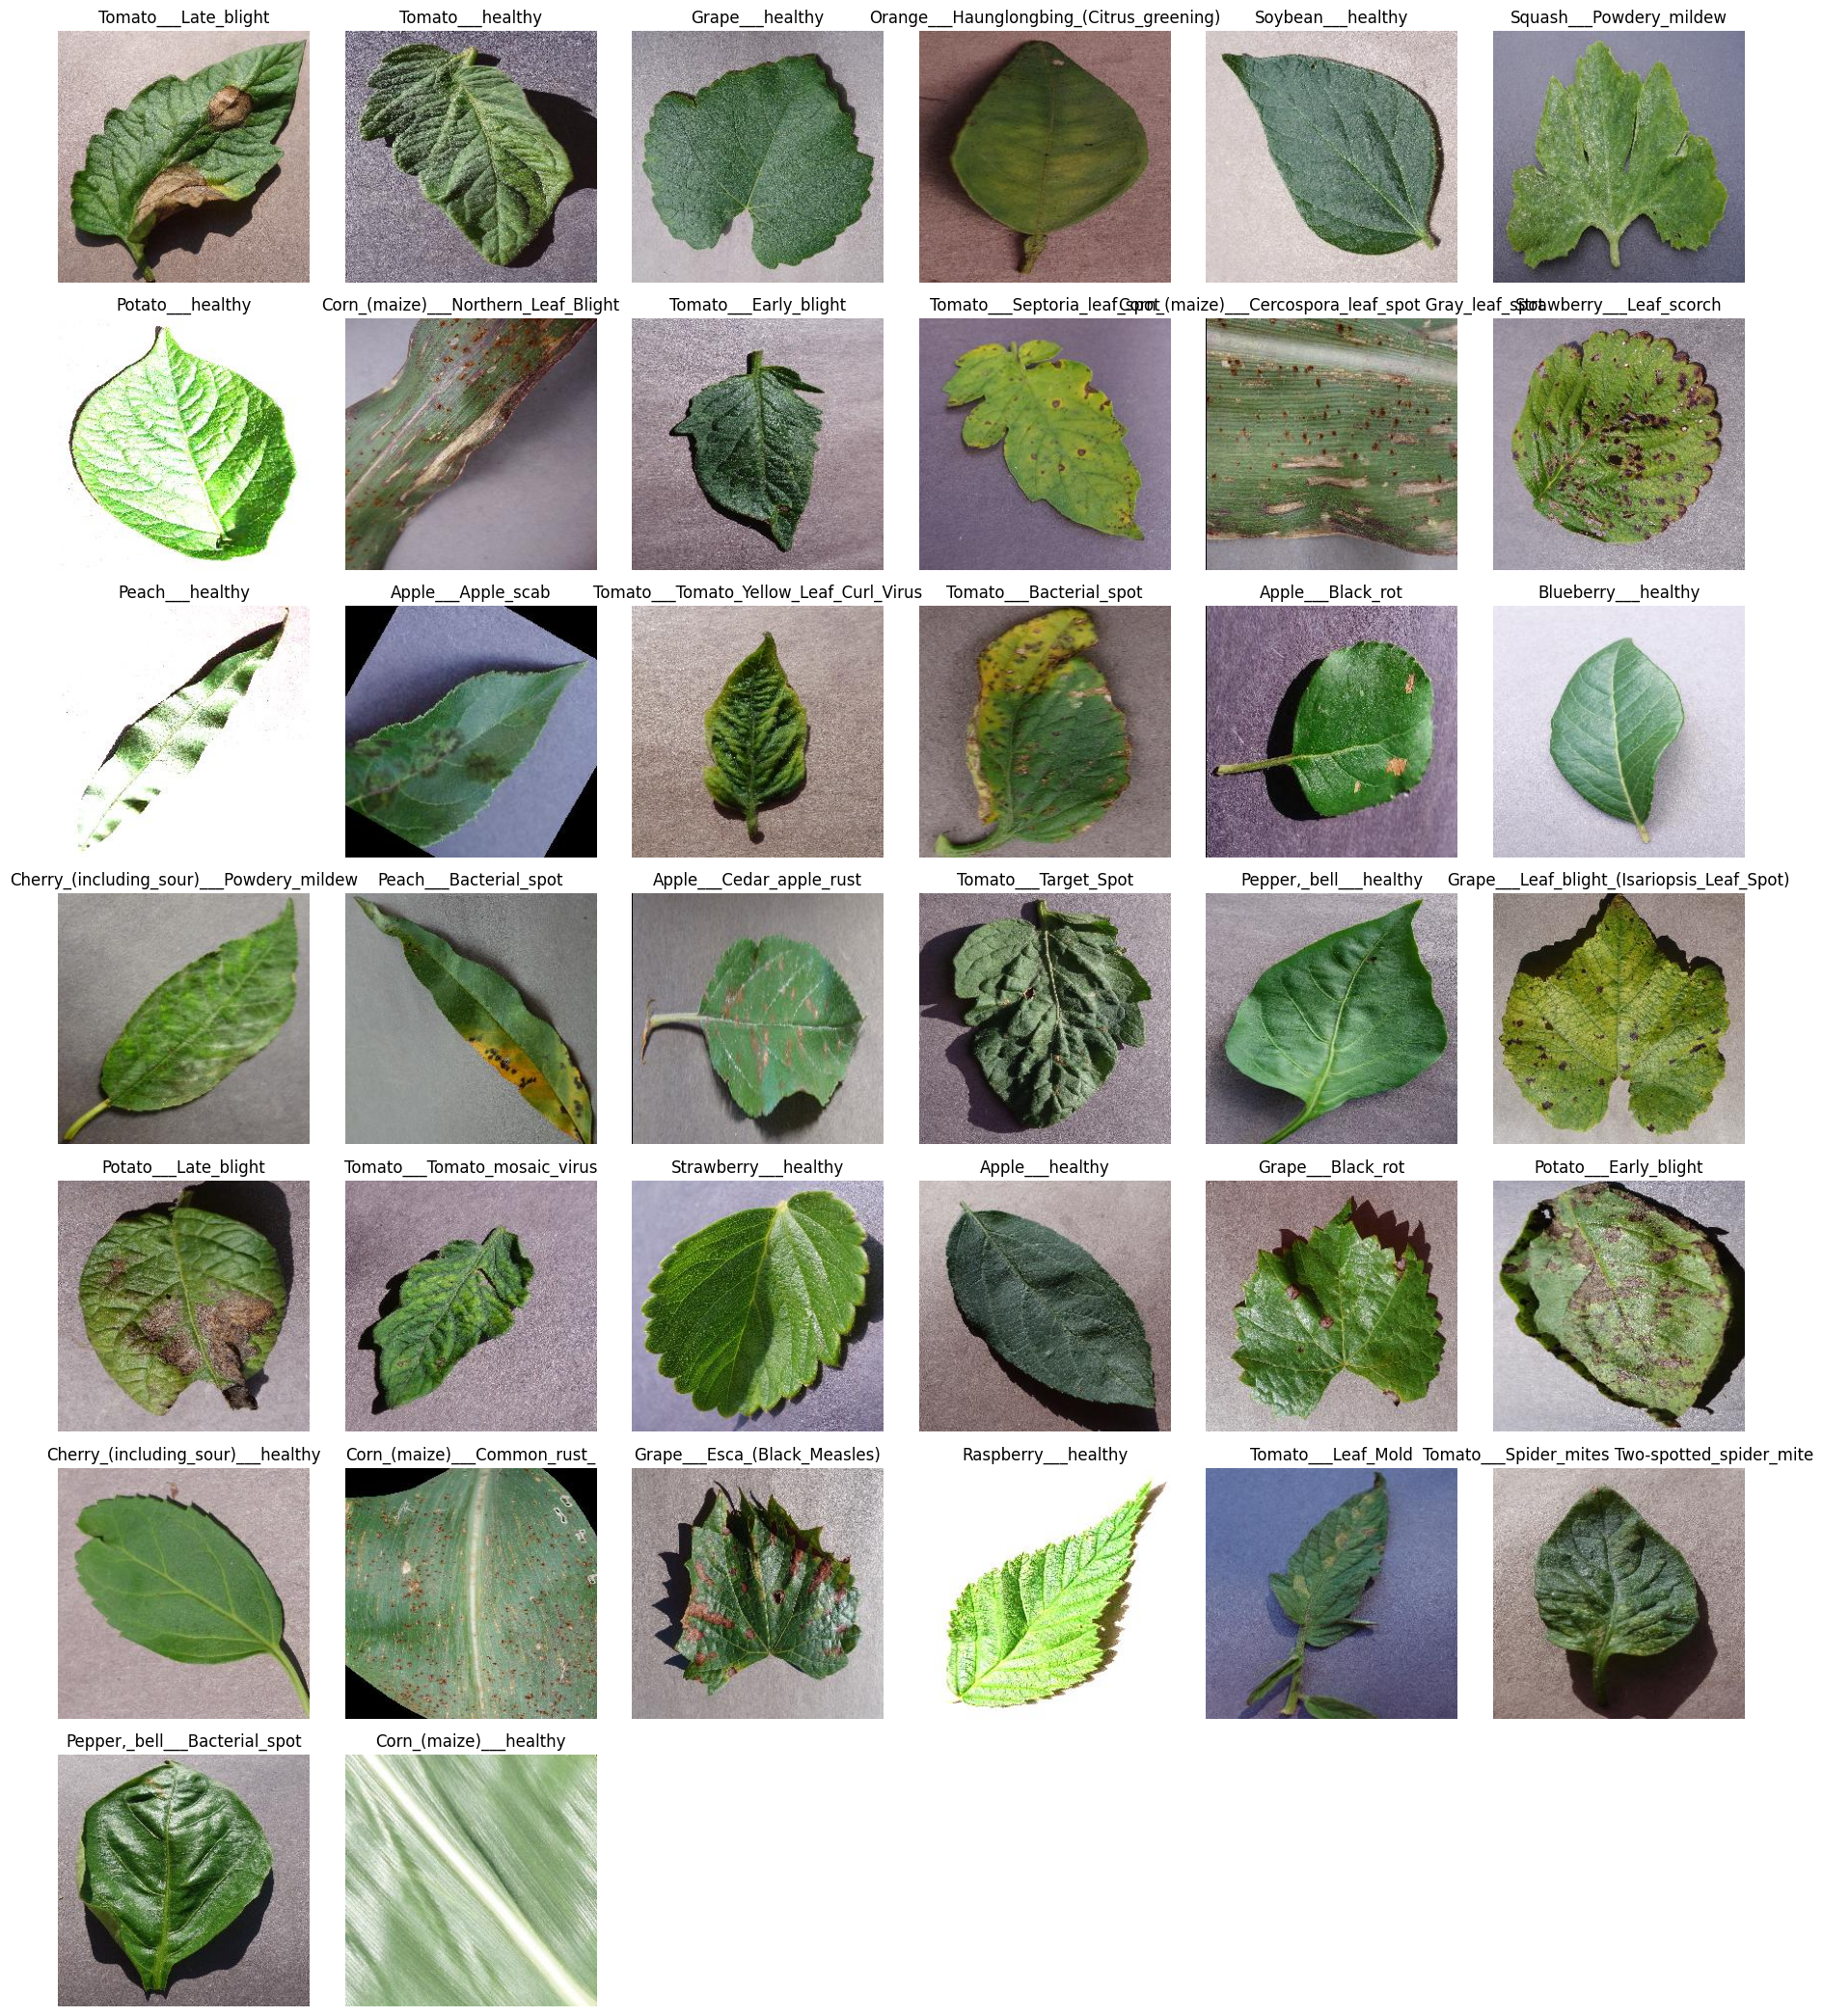

In [13]:

classes = [name for name in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, name))]

images = []
for class_name in classes:
    class_dir = os.path.join(train_path, class_name)
    img_name = random.choice(os.listdir(class_dir))
    img_path = os.path.join(class_dir, img_name)
    img = Image.open(img_path)
    images.append((class_name, img))


num_classes = len(images)
cols = 6
rows = math.ceil(num_classes / cols)

plt.figure(figsize=(3*cols, 3*rows))

for i, (class_name, img) in enumerate(images):
    ax = plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [14]:
def compute_mean_std(dataset):
    loader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=2)
    mean = 0.
    std = 0.
    total_images = 0

    for images, _ in tqdm(loader):
        batch_samples = images.size(0)  # batch size (N)
        images = images.view(batch_samples, images.size(1), -1)  # [N, C, H*W]
        mean += images.mean(2).sum(0)
        std  += images.std(2).sum(0)
        total_images += batch_samples

    mean /= total_images
    std /= total_images
    return mean, std

tmp_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
tmp_dataset = datasets.ImageFolder(root=train_path, transform=tmp_transform)

mean, std = compute_mean_std(tmp_dataset)
print("Mean:", mean)
print("Std:", std)


100%|██████████| 1099/1099 [03:42<00:00,  4.94it/s]

Mean: tensor([0.4760, 0.5004, 0.4266])
Std: tensor([0.1775, 0.1509, 0.1960])


In [15]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4760, 0.5004, 0.4266],
                         std=[0.1775, 0.1509, 0.1960]),
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4760, 0.5004, 0.4266],
                         std=[0.1775, 0.1509, 0.1960]),
])


In [16]:
new_transformed_img = train_transform(img)
print(new_transformed_img)

tensor([[[-2.6817, -2.6817, -2.6817,  ..., -2.6817, -2.6817, -2.6817],
         [-2.6817, -2.6817, -2.6817,  ..., -2.6817, -2.6817, -2.6817],
         [-2.6817, -2.6817, -2.6817,  ..., -2.6817, -2.6817, -2.6817],
         ...,
         [-2.6817, -2.6817, -2.6817,  ..., -2.6817, -2.6817, -2.6817],
         [-2.6817, -2.6817, -2.6817,  ..., -2.6817, -2.6817, -2.6817],
         [-2.6817, -2.6817, -2.6817,  ..., -2.6817, -2.6817, -2.6817]],

        [[-3.3161, -3.3161, -3.3161,  ..., -3.3161, -3.3161, -3.3161],
         [-3.3161, -3.3161, -3.3161,  ..., -3.3161, -3.3161, -3.3161],
         [-3.3161, -3.3161, -3.3161,  ..., -3.3161, -3.3161, -3.3161],
         ...,
         [-3.3161, -3.3161, -3.3161,  ..., -3.3161, -3.3161, -3.3161],
         [-3.3161, -3.3161, -3.3161,  ..., -3.3161, -3.3161, -3.3161],
         [-3.3161, -3.3161, -3.3161,  ..., -3.3161, -3.3161, -3.3161]],

        [[-2.1765, -2.1765, -2.1765,  ..., -2.1765, -2.1765, -2.1765],
         [-2.1765, -2.1765, -2.1765,  ..., -2

In [17]:
train_dataset = datasets.ImageFolder(root=train_path, transform=train_transform)
val_dataset   = datasets.ImageFolder(root=val_path, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

print("Train dataset size:", len(train_dataset))
print("Validation dataset size:", len(val_dataset))

print("Train loader size:", len(train_loader))
print("Validation loader size:", len(val_loader))

# train_dataset.class_to_idx.items()


Train dataset size: 70295
Validation dataset size: 17572
Train loader size: 2197
Validation loader size: 550


In [18]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=38):
        super(SimpleCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SimpleCNN(num_classes=38).to(device)

In [19]:
# Loss and Optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [20]:
num_epochs = 7

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = loss_fn(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}, Accuracy: {train_acc:.2f}%")

   ## Validation loop
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    val_acc = 100 * val_correct / val_total
    print(f"Validation Accuracy: {val_acc:.2f}%")


Epoch [1/7], Loss: 1.0811, Accuracy: 67.83%
Validation Accuracy: 83.89%
Epoch [2/7], Loss: 0.2968, Accuracy: 90.45%
Validation Accuracy: 91.99%
Epoch [3/7], Loss: 0.2040, Accuracy: 93.41%
Validation Accuracy: 93.64%
Epoch [4/7], Loss: 0.1703, Accuracy: 94.54%
Validation Accuracy: 94.09%
Epoch [5/7], Loss: 0.1391, Accuracy: 95.59%
Validation Accuracy: 95.53%
Epoch [6/7], Loss: 0.1304, Accuracy: 95.94%
Validation Accuracy: 95.60%
Epoch [7/7], Loss: 0.1208, Accuracy: 96.22%
Validation Accuracy: 95.95%


In [21]:
model.eval()

SimpleCNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=100352, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=38, bias=True)
  )
)

In [22]:
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4760, 0.5004, 0.4266],
                         std=[0.1775, 0.1509, 0.1960]),
])


In [23]:
class DirectImageDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(img_dir) if f.lower().endswith(('.jpg','.jpeg','.png'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.image_files[idx])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, self.image_files[idx]


test_path = "../kaggle/input/new-plant-diseases-dataset/test/test"


test_dataset = DirectImageDataset(test_path, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

print("Number of test images:", len(test_dataset))

Number of test images: 33


In [24]:

predictions = []

with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        predicted = predicted.cpu().numpy()
        predictions.extend(predicted)

# Print first 10 predictions
print(predictions[:10])


[np.int64(29), np.int64(35), np.int64(35), np.int64(22), np.int64(35), np.int64(20), np.int64(29), np.int64(34), np.int64(8), np.int64(25)]


In [25]:

torch.save(model.state_dict(), "cnn_model_weights.pth")
print("Model weights saved!")


Model weights saved!


In [26]:

model_loaded = SimpleCNN(num_classes=38)
model_loaded.load_state_dict(torch.load("cnn_model_weights.pth"))
model_loaded.to(device)
model_loaded.eval()

print("Model weights loaded!")


Model weights loaded!


In [27]:
predictions_loaded = []

with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        outputs = model_loaded(images)
        _, predicted = torch.max(outputs.data, 1)
        predicted = predicted.cpu().numpy()
        predictions_loaded.extend(predicted)

# Check predictions
print(predictions_loaded[:10])


[np.int64(29), np.int64(35), np.int64(35), np.int64(22), np.int64(35), np.int64(20), np.int64(29), np.int64(34), np.int64(8), np.int64(25)]
